# [Exploration 05] Spectrogram Classification
- 2차원의 spectrogram 데이터를 분류하는 task
- 기본 모델과 skip connection을 사용한 모델로 나누어 성능을 비교한다. 
- data source : [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)

# 1-dimension wav file classification
spectrogram 데이터를 다루기 전(변환 전) wav 파일을 이용해서 분류해보겠다.(데이터 간의 성능비교를 위해)
## 1. load data 

In [5]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print(speech_data)
print(speech_data.keys())
print(speech_data.values())


KeysView(<numpy.lib.npyio.NpzFile object at 0x7faef85e0790>)
ValuesView(<numpy.lib.npyio.NpzFile object at 0x7faef85e0790>)


- speech_data는 wav_vals, label_vals로 이루어져있다.

In [6]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [7]:
print(speech_data["wav_vals"][0])
print(len(speech_data["wav_vals"][0]))
print(speech_data["label_vals"])

[-1.27418665e-04 -1.12644804e-04 -1.86756923e-04 ... -1.62762426e-05
 -4.93293861e-04 -3.55132594e-04]
8000
[['down']
 ['down']
 ['down']
 ...
 ['silence']
 ['silence']
 ['silence']]


- data는 총 50,620개
- 모두 1초 음성데이터이다. 
- sampling rate : 8,000   


- data 확인

In [8]:
import IPython.display as ipd
import random

rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # sampling rate : 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  20348
Wave data shape :  (8000,)
label :  ['yes']


## 2. data 전처리
- text로 된 label data 처리 
- split data set    



- label data 확인

In [9]:
labels = speech_data["label_vals"]
np.unique(labels)

array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence',
       'stop', 'unknown', 'up', 'yes'], dtype='<U7')

- 'unkown', 'silence'를 추가한다.
- 각 label에 인덱스를 부여한다.

In [10]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


- 위에서 만들어 둔 index를 이용해 label data를 숫자(index)로 바꾼다. 

In [11]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

- data split : sklearn.model_selection을 이용한다. 

In [38]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
#print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # CNN모델에 넣기 위해 차원을 늘려준다. 
test_wav = test_wav.reshape([-1, sr, 1])

print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)


## 3. data setting
- tf.data.Dataset 을 이용해 데이터셋을 구성한다. 
- 데이터셋 전처리, 배치처리를 쉽게할 수 있는 패키지

In [13]:
# one hot encoding 해주는 함수
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

### hyper parameter 조정 

In [20]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj26/aiffel/speech_recognition/models/wav'

In [15]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
# map함수를 사용하면, 함수를 매핑할 수 있다.
train_dataset = train_dataset.map(one_hot_label)
# repeat() : data를 반복호출한다.
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 4. wave classification 모델 구현 
- 1차원으로 구성한 데이터를 분류할 수 있는 CNN 모델을 구축한다.

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

In [18]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

- 가장 성능이 좋은 모델을 checkpoint directory에 저장한다.

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [22]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/5
1423/1423 [==============================] - ETA: 0s - loss: 1.4095 - accuracy: 0.5311
Epoch 00001: val_loss improved from inf to 0.95853, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 171s 120ms/step - loss: 1.4095 - accuracy: 0.5311 - val_loss: 0.9585 - val_accuracy: 0.7053
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.7984 - accuracy: 0.7530
Epoch 00002: val_loss improved from 0.95853 to 0.74234, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 173s 121ms/step - loss: 0.7984 - accuracy: 0.7530 - val_loss: 0.7423 - val_accuracy: 0.7603
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.8283
Epoch 00003: val_loss improved from 0.74234 to 0.58828, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 172s 121ms/st

## 5. visualize model training history

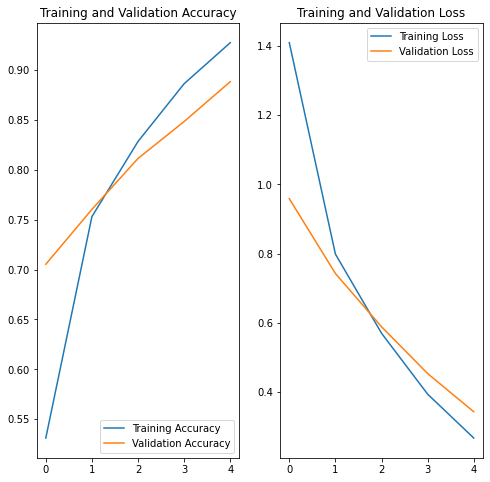

In [23]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. evaluate with best model weights

In [26]:
model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)
print(results)

159/159 [==============================] - 14s 89ms/step - loss: 0.3423 - accuracy: 0.8884
[0.34234097599983215, 0.8883840441703796]


In [27]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.342
accuracy value: 88.8384%


## 7. test model
- 음성 파일을 확인해 예측한 결과를 확인한다.

In [28]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  down


In [29]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: down(Correct!)


# spectrogram classification
- 1차원의 데이터를 spectrogram으로 변환한다. 

## 1. data 전처리
- data를 가져온다. 위 코드에서 사용한 데이터를 사용한다. 
- train, validation으로 나눈다.

In [5]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print(speech_data)
print(speech_data.keys())
print(speech_data.values())
print(type(speech_data['wav_vals'][0]))

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f5a6e9ee750>)
ValuesView(<numpy.lib.npyio.NpzFile object at 0x7f5a6e9ee750>)
<class 'numpy.ndarray'>


In [7]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [9]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

## 2. data setting
- wav2spec 함수를 매핑해서 데이터셋을 변환한다. 

In [2]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [2]:
del speech_data

NameError: name 'speech_data' is not defined

In [3]:
spec_data = speech_data["wav_vals"].map(wav2spec)

AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [35]:
print('Indexed LABEL : ', label_value)

Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [11]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(type(train_wav))
train_wav = train_wav.map(wav2spec)

train_wav = train_wav.reshape([-1, sr, 1]) # CNN모델에 넣기 위해 차원을 늘려준다. 
test_wav = test_wav.reshape([-1, sr, 1])

print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

<class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'map'

### hyper parameter 조정 

In [41]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/aiffel-dj26/aiffel/speech_recognition/models/spec'

In [33]:
# 1차원 데이터에서 샘플로 뽑은 data
# data = speech_data["wav_vals"][rand]

spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


- spectrogram 확인 

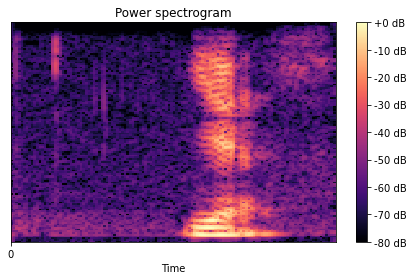

In [34]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [44]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

TypeError: in user code:

    <ipython-input-32-6ac2f57e8a50>:4 wav2spec  *
        D = np.abs(librosa.stft(wav, n_fft=fft_size))
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/librosa/core/spectrum.py:208 stft  *
        fft_window = get_window(window, win_length, fftbins=True)
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/librosa/filters.py:884 get_window  *
        return scipy.signal.get_window(window, Nx, fftbins=fftbins)
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/scipy/signal/windows/windows.py:2121 get_window  *
        return winfunc(*params)
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/scipy/signal/windows/windows.py:787 hann  *
        return general_hamming(M, 0.5, sym)
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/scipy/signal/windows/windows.py:1017 general_hamming  *
        return general_cosine(M, [alpha, 1. - alpha], sym)
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/scipy/signal/windows/windows.py:109 general_cosine  *
        if _len_guards(M):
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/scipy/signal/windows/windows.py:18 _len_guards  *
        if int(M) != M or M < 0:
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1502 tensor_not_equals
        return gen_math_ops.not_equal(self, other, incompatible_shape_error=False)
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:6422 not_equal
        name=name)
    /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:506 _apply_op_helper
        inferred_from[input_arg.type_attr]))

    TypeError: Input 'y' of 'NotEqual' Op has type int64 that does not match type int32 of argument 'x'.


# 정리
---
1. 네이버 영화리뷰 dataset을 load한다.   
    - pd.read_tabel 을 이용하면 데이터를 표로 읽어올 수 있다. 
    - 데이터 description을 출력해 해당 데이터의 특성을 파악한다.
2. 데이터셋을 가공할 함수를 만든다.   
    - 중복된 데이터와 결측치를 제거한다.
    - 문장을 토크나이저로 토큰화한다. 
    - 불용어는 제거한다.
    - word_to_index, index_to_word를 구성한다.
3. 데이터의 분포를 확인해 패딩할 최대 길이를 선정한다.
    - 최대 길이는 (평균 + 2\*표준편차)로 계산하였다. (41)
4. 문장 앞에 패딩을 해 길이를 맞춘다.
5. train, valid 로 dataset을 나눈다. 
6. 모델을 설계한다.
    - 첫번째 레이어는 embedding layer로 구성한다.
7. pretrain된 word2vec을 활용해 embedding layer를 구성한다.
    - word2vec을 활용하면 단어간 유사도를 판별할 수 있다.
8. 학습시킨 후 그래프 시각화를 통해 과적합을 판별해 파라미터를 조정한다.


# 루브릭 평가
---
1. **음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.**   
    - 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.

    
2. **1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.**  
    - 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
    
    
3. **테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.**  
    - evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.

    
# 회고
---
## 더 공부하고 싶은 부분
- embedding layer의 원리
- lstm 연산
- vector dimension
- callback함수를 사용해 earlystopping하는 것과 그래프로 확인해 에폭을 줄이는 것의 성능차이가 있을까?  

## 느낀 점
아직 RNN, NLP에 대해 부족한 부분이 많아 연산을 생각하며 모델을 구성하지 못한 점이 아쉬웠다. 문장을 토큰화하고, 벡터화하고 여러 전처리 과정에서 문장의 의미, 맥락, 단어들의 유사도 등 의미있는 데이터를 손상하지 않기위한 고민이 많이 필요하다는 것을 알게되었다. 더 재미있는 task도 빨리 만나고 싶다.